# How to Scrape a Dashboard with Python 
Dashboard scraping is a useful skill to have when the only way to interact with the data you need is through a dashboard. We're going to learn how to scrape data from a dashboard using the [Selenium](https://selenium-python.readthedocs.io/) and [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) packages in Python. The Selenium package allows you to write Python code to automate web browser interaction, and the Beautiful Soup package allows you to easily pull data from the HTML code that produces the webpage you want to scrape. 

Our goal is to scrape the [Fort Bend County Community Impact Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/75133e049f584ae8b51dc6cba740009a) that visualizes the COVID-19 situation in Fort Bend County in Texas. We will extract the history of total tests performed and the daily case counts reported so that we can estimate the percent of positive cases in Fort Bend County.

Note that all of the code in this tutorial is written in Python version 3.6.2.

## Step 1 - Import Python Packages, Modules and Methods
The first step is to import the Python packages, modules, and methods needed for dashboard scraping. The versions of the packages used in this tutorial are listed below.

| Package | Version | Description |
| --: | :--: | :-- |
| bs4        | 0.0.1  | Beautiful Soup is used to pull data from XML and HTML files.  |
| selenium   | 3.14.0 | Selenium is used to automate web browser interaction. |
| pandas     | 0.20.3 | Pandas is used for data manipulation. |
| matplotlib | 2.0.2  | Matplotlib is used for plotting. |

In [1]:
# Import packages for ...
## pulling data from XML and HTML files
from bs4 import BeautifulSoup 

## automating web browser interaction
from selenium import webdriver # module containing implementations of browser drivers
from webdriver_manager.chrome import ChromeDriverManager # Chrome driver 
from selenium.webdriver.support import expected_conditions as EC # method for writing code that waits until conditions are met 
from selenium.webdriver.support.ui import WebDriverWait # method for writing code that implements implicit or explicit waits
from selenium.webdriver.common.by import By # method for locating elements by their attributes
from selenium.webdriver import ActionChains # module for implementing browser interactions 

## data manipulation
import pandas as pd
from datetime import datetime
import numpy as np

## plotting
import matplotlib.pyplot as plt

## Step 2 - Scrape HTML Source Code
The next step is to write Python code to automate our interaction with the dashboard. Before writing any code, we must look at the dashboard and inspect the source code to identify the HTML elements that contain the data we need. The dashboard source code refers to the HTML code that tells your browser how to render the dashboard web page. To view the dashboard source code, navigate to the dashboard and use the keyboard shortcut ``Ctrl+Shift+I``. An interactive panel containing the dashboard source code will appear. 

Notice that the history of total tests performed and the daily case counts reported are only visible after clicking the "History" tab in the "Total Numbers of Tests Performed at County Sites" panel and the "Daily Case Count" tab in the "Confirmed Cases" panel, respectively. This means that we need to write Python code that automatically clicks on the "History" and "Daily Case Count" tabs so that the history of total tests performed and the daily case counts reported will be visible to Beautiful Soup. 

![](COVID_FB_files/dashboard-overview.png "Fort Bend County Community Impact Dashboard on July 10th, 2020")

To find the HTML element that contains the "History" tab, use the shortcut ``Ctrl+Shift+C`` and then click on the "History" tab. You will see in the source code panel that the "History" tab is in a div element with ID "ember208". 

![](COVID_FB_files/history-html.png "History Tab Source Code")

Following the same steps for the "Daily Case Count" tab, you will see that the "Daily Case Count" tab is in a div element with ID "ember238".

![](COVID_FB_files/daily-case-count-html.png "Daily Case Count Tab Source Code")


Now that we have identified the elements we need, we can write code that:
1. Launches the dashboard in Chrome
2. Clicks on the "History" tab once the "History" tab finishes loading
3. Clicks on the "Daily Case Count" tab once the "Daily Case Count" tab finishes loading
4. Extracts the dashboard HTML source code 
5. Exits Chrome

In [2]:
# Initialize Chrome browser and launch the dashboard in Chrome
driver = webdriver.Chrome(ChromeDriverManager().install())
url = 'https://www.arcgis.com/apps/opsdashboard/index.html#/75133e049f584ae8b51dc6cba740009a'
driver.get(url)

# Wait for element containing history of tests performed to load
delay = 10
try:
    element_present = EC.presence_of_element_located((By.ID, 'ember208'))
    WebDriverWait(driver, delay).until(element_present)
except TimeoutException:
    print('Timed out waiting for page to load')

# Click on history of tests performed 
element1 = driver.find_element_by_id("ember208")
ActionChains(driver).click(element1).perform()

# Wait for element containing history of reported cases to load
try:
    element_present = EC.presence_of_element_located((By.ID, 'ember238'))
    WebDriverWait(driver, delay).until(element_present)
except TimeoutException:
    print('Timed out waiting for page to load')

# Click on history of reported positive cases 
element2 = driver.find_element_by_id("ember238")
ActionChains(driver).click(element2).perform()

# Extract and store page HTML
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

[WDM] - Current google-chrome version is 84.0.4147
[WDM] - Get LATEST driver version for 84.0.4147
[WDM] - Driver [C:\Users\karla\.wdm\drivers\chromedriver\win32\84.0.4147.30\chromedriver.exe] found in cache


# Step 3 - Parse Data from HTML
Now, we need to parse the HTML source code to extract the history of total tests performed and the daily case counts reported. We will begin by looking at the dashboard source code to identify the HTML elements that contain the data.

To find the div element that contains the history of total tests performed, use the `Ctrl+Shift+C` shortcut and then click in the general area of the "Testing Sites" plot. You will see in the source code that the entire plot is in the div element with ID "ember96".

![](COVID_FB_files/history-plot.png "Testing Sites Plot Source Code")

If you hover over a specific data point, a label containing the date and number of tests performed will appear. Use the `Ctrl+Shift+C` shortcut and click on a specific data point. You will see that the label text is stored as the `aria-label` attribute of a `g` element.

![](COVID_FB_files/history-label.png "Testing Sites Data Labels Source Code")

Following the same steps for the daily case counts reported, you will see that the plot of daily case counts is in the div element with ID "ember143".

![](COVID_FB_files/daily-case-count-plot.png "Daily Cases based on Report Date Plot Source Code")

If you hover over a specific data point, a label containing the date and the number of positive cases reported will appear. Using the `Ctrl+Shift+C` shortcut, you will notice that the data are also stored in the `aria-label` attribute of `g` elements.

![](COVID_FB_files/daily-case-count-label.png "Daily Cases based on Report Date Data Labels Source Code")


Once we have the elements that contain the data, we can write code that:
1. Finds the div element that contains the plot of the total tests performed and pulls the total tests performed data
2. Finds the div element that contains the plot of the daily case counts and pulls the daily case count data
3. Combines the data in a pandas dataframe and exports it to a CSV

In [3]:
# Extract <div> containing data on total tests performed
elements_total_tests = soup.findAll('div', {'id': 'ember96'})[0].findAll('g')

# Parse and extract data on total tests performed
total_tests = {'Date': [], 'Total_Tests': []}
for element in elements_total_tests:
    try:
        split_element = element['aria-label'].split()
        total_tests['Total_Tests'].append( int(split_element[-1].replace(',', '')) )
        total_tests['Date'].append( ' '.join(split_element[4:7]) )
    except:
        pass

# Extract <div> containing data on total positive cases 
elements_total_positive_cases = soup.findAll('div', {'id': 'ember143'})[0].findAll('g')

# Parse and extract data on total positive cases
total_positive_cases = {'Date': [], 'Total_Cases': []}
for element in elements_total_positive_cases:
    try:
        split_element = element['aria-label'].split()
        total_positive_cases['Total_Cases'].append( int(split_element[-1].replace(',', '')) )
        total_positive_cases['Date'].append( ' '.join(split_element[2:5]) )
    except:
        pass
    
# Convert dict to pandas df
total_tests_df = pd.DataFrame.from_dict(total_tests)
total_positive_cases_df = pd.DataFrame.from_dict(total_positive_cases)

# Fix formatting
total_tests_df['Date'] = pd.to_datetime(total_tests_df['Date'], format='%b %d, %Y')
total_tests_df.set_index('Date', inplace=True)
total_positive_cases_df['Date'] = pd.to_datetime(total_positive_cases_df['Date'], format='%b %d, %Y')
total_positive_cases_df.set_index('Date', inplace=True)

# Merge data and save as csv
data = total_tests_df.join(total_positive_cases_df, how='outer').reset_index()
data.to_csv('covid_fortbend.csv', index=False)

## Step 4 - Calculate Positivity Rate
Now, we can finally estimate the COVID-19 positivity rate in Fort Bend County. We will divide the cases reported by the tests performed and calculate the 7-day moving averages. It is unclear from the dashboard whether the reported positive cases include cases that were determined through tests not conducted by the county (e.g. tests conducted at a hospital or clinic). It is also unclear when the tests for the positive cases were conducted since the dashboard only displays the reported case date. That is why the positivity rates derived from these data are only considered a proxy for the true positivity rate.

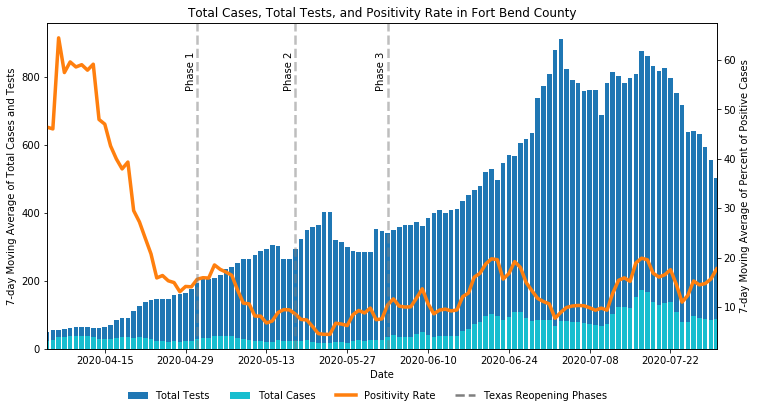

In [4]:
# Only include from 3/30/2020 - Present since free county testing started on 3/30/2020
data = data.loc[data.Date >= '2020-03-30'].reset_index(drop=True)

# Replace NaN values with 0s (Most NaNs are on Sundays and testing sites are closed on Sundays)
data.fillna(0, inplace=True) 

# Set Date as index
data.set_index('Date', inplace=True)

# Check for missing dates
missing_dates = pd.date_range(start='2020-03-30', end=max(data.index)).difference(data.index)
for dt_index in missing_dates:
    data.loc[dt_index] = [0, 0]
data = data.loc[data.index.sort_values()] # Ensure chronological order is preserved

# Calculate the positivity ratio
data['Positivity_Ratio'] = 100 * data['Total_Cases'].rolling(window=7).sum() / data['Total_Tests'].rolling(window=7).sum()
data.replace([np.inf, -np.inf], 0, inplace=True)

# Plot total cases, tests, and positivity ratio
fig = plt.figure(figsize=(12,6))
barchart1 = plt.bar(data.index, data['Total_Tests'].rolling(window=7).mean(), color='tab:blue')
barchart2 = plt.bar(data.index, data['Total_Cases'].rolling(window=7).mean(), color='tab:cyan')
plt.xlabel('Date')
plt.ylabel('7-day Moving Average of Total Cases and Tests')
plt.twinx()
linechart = plt.plot(data.index, data['Positivity_Ratio'], color='tab:orange', linewidth=3.5)
plt.title('Total Cases, Total Tests, and Positivity Rate in Fort Bend County')
plt.ylabel('7-day Moving Average of Percent of Positive Cases')
plt.xlim(data.loc[~data.isnull().any(axis=1)].index[0], data.loc[~data.isnull().any(axis=1)].index[-1])

# Denote Texas phases of reopening
phase1_dt = '2020-05-01'
phase2_dt = '2020-05-18'
phase3_dt = '2020-06-03'
plt.axvline(x=phase1_dt, linewidth=2.5, linestyle='--', color='tab:gray', alpha=0.5)
plt.axvline(x=phase2_dt, linewidth=2.5, linestyle='--', color='tab:gray', alpha=0.5)
plt.axvline(x=phase3_dt, linewidth=2.5, linestyle='--', color='tab:gray', alpha=0.5)
plt.text('2020-05-29', 60,'Phase 1', rotation=90)
plt.text('2020-05-16', 60,'Phase 2', rotation=90)
plt.text('2020-06-01', 60,'Phase 3', rotation=90)

# Add legend
orange_line = plt.Line2D([], [], color='tab:orange', linewidth=3.5)
gray_line = plt.Line2D([], [], color='tab:gray', linewidth=2.5, linestyle='--')
plt.legend((barchart1, barchart2, orange_line, gray_line), 
           ('Total Tests', 'Total Cases', 'Positivity Rate', 'Texas Reopening Phases'), 
           ncol=4, bbox_to_anchor=(0.85, -0.1), frameon=False)
plt.show()

## Sources
1. https://www.fbchealth.org/ncov/
2. https://www.fortbendcountytx.gov/your-county/fort-bend-county-expands-covid-19-testing-site-to-all-residents
3. https://gov.texas.gov/news/post/governor-abbott-announces-phase-one-to-open-texas-establishes-statewide-minimum-standard-health-protocols
4. https://gov.texas.gov/news/post/governor-abbott-announces-phase-two-to-open-texas
5. https://gov.texas.gov/news/post/governor-abbott-announces-phase-iii-to-open-texas